In [1]:
import bernstein_coeff_order10_arbitinterval
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax


In [2]:

tot_time = np.linspace(0, 2.5, 50)
tot_time_copy = tot_time.reshape(50, 1)
P, Pdot, Pddot = bernstein_coeff_order10_arbitinterval.bernstein_coeff_order10_new(10, tot_time_copy[0], tot_time_copy[-1], tot_time_copy)


In [6]:
print(P.shape, Pdot.shape, Pddot.shape)

(50, 11) (50, 11) (50, 11)


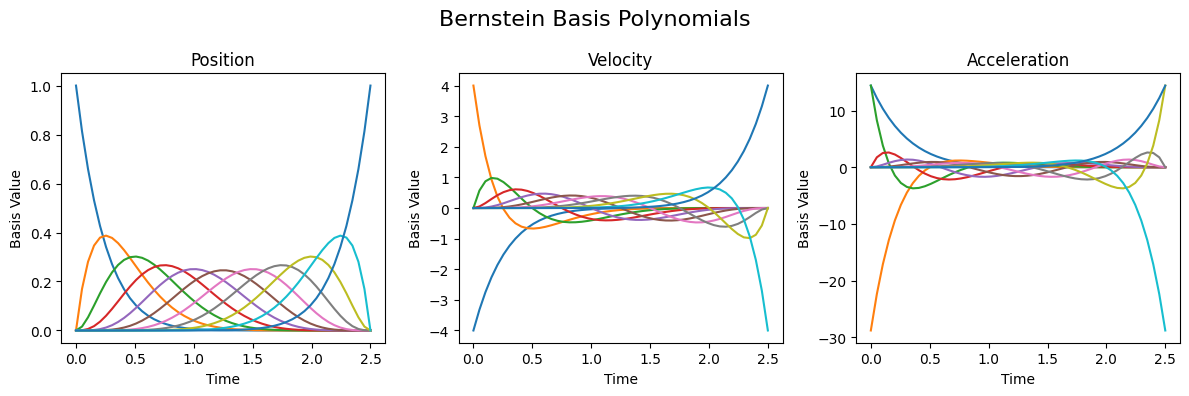

In [9]:

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
fig.suptitle('Bernstein Basis Polynomials', fontsize=16)
axs = axs.flatten() 

axs[0].plot(tot_time, P)
axs[0].set_title("Position")
axs[0].set_xlabel("Time")
axs[0].set_ylabel("Basis Value")

axs[1].plot(tot_time, Pdot)
axs[1].set_title("Velocity")
axs[1].set_xlabel("Time")
axs[1].set_ylabel("Basis Value")

axs[2].plot(tot_time, Pddot)
axs[2].set_title("Acceleration")
axs[2].set_xlabel("Time")
axs[2].set_ylabel("Basis Value")

plt.tight_layout()
plt.savefig("polynomials.png")
plt.show()

In [10]:
A_theta = np.kron(np.identity(6), P)
A_thetadot = np.kron(np.identity(6), Pdot)
A_thetaddot = np.kron(np.identity(6), Pddot)

In [24]:
print(A_theta.shape)
print(np.identity(6))
print(np.eye(2))

(300, 66)
[[1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]]
[[1. 0.]
 [0. 1.]]


NameError: name 'A_theta' is not defined

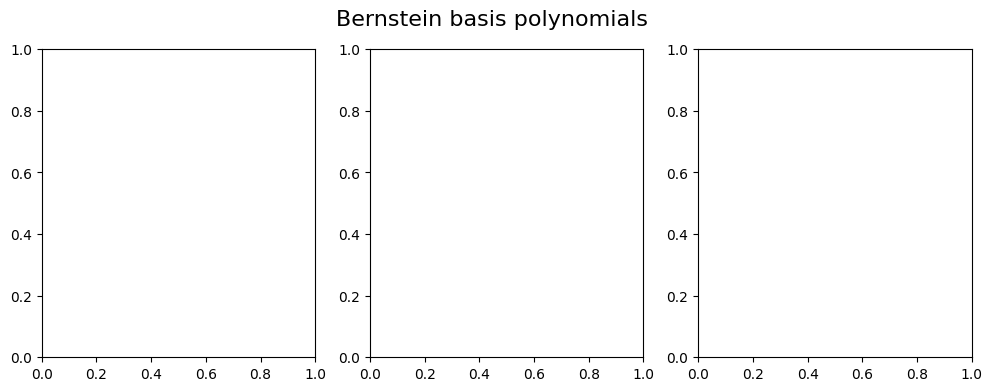

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs = axs.flatten() 


axs[0].plot(A_theta.reshape(6, 50, 66)[0])
axs[0].set_title("P")
axs[0].set_xlabel("Time")
axs[0].set_ylabel("Basis Value")

axs[1].plot(A_thetadot.reshape(6, 50, 66)[0])
axs[1].set_title("P dot")
axs[1].set_xlabel("Time")
axs[1].set_ylabel("Basis Value")

axs[2].plot(A_thetaddot.reshape(6, 50, 66)[0])
axs[2].set_title("P ddot")
axs[2].set_xlabel("Time")
axs[2].set_ylabel("Basis Value")

plt.tight_layout()
plt.show()

In [11]:
num_dof = 6
nvar = 66

In [12]:
def get_A_p():
    A_p = np.vstack(( P, -P     ))
    A_p_ineq = np.kron(np.identity(num_dof), A_p )
    return A_p_ineq, A_p
	
def get_A_v():
    A_v = np.vstack(( Pdot, -Pdot     ))
    A_v_ineq = np.kron(np.identity(num_dof), A_v )
    return A_v_ineq, A_v

def get_A_a():
    A_a = np.vstack(( Pddot, -Pddot  ))
    A_a_ineq = np.kron(np.identity(num_dof), A_a )
    return A_a_ineq, A_a

def get_A_eq():
		return np.kron(np.identity(num_dof), np.vstack((P[0], Pdot[0], Pddot[0], Pdot[-1], Pddot[-1]    )))
	
def get_Q_inv(A_eq):
    rho_ineq = 1
    Q_inv = np.linalg.inv(
            np.vstack((
                    np.hstack(( 
                        np.dot(A_projection.T, A_projection)+rho_ineq*jnp.dot(A_v_ineq.T, A_v_ineq)+rho_ineq*jnp.dot(A_a_ineq.T, A_a_ineq)+rho_ineq*jnp.dot(A_p_ineq.T, A_p_ineq), 
                        A_eq.T
                    )), 
                    np.hstack((A_eq, np.zeros((np.shape(A_eq)[0], np.shape(A_eq)[0]))
                ))
            ))
        )	
    return Q_inv

A_projection = jnp.identity(nvar)

A_v_ineq, A_v = get_A_v()
A_v_ineq = jnp.asarray(A_v_ineq) 
A_v = jnp.asarray(A_v)

A_a_ineq, A_a = get_A_a()
A_a_ineq = jnp.asarray(A_a_ineq) 
A_a = jnp.asarray(A_a)

A_p_ineq, A_p = get_A_p()
A_p_ineq = jnp.asarray(A_p_ineq) 
A_p = jnp.asarray(A_p)

A_eq = get_A_eq()
A_eq = jnp.asarray(A_eq)

Q_inv = get_Q_inv(A_eq)
Q_inv = jnp.asarray(Q_inv)

In [13]:
def compute_boundary_vec_single(state_term):
	num_dof = 6

	b_eq_term = state_term.reshape(5, num_dof).T
	b_eq_term = b_eq_term.reshape(1, num_dof*5)
	return b_eq_term

def compute_projection_filter(xi_samples, state_term):
		
	num_batch = 1
	num = 50
	num_dof = 6
	maxiter_projection = 10

	b_eq_term = compute_boundary_vec_single(state_term)
	s_v = jnp.zeros((num_batch, 2*num_dof*num   ))
	s_a = jnp.zeros((num_batch, 2*num_dof*num   ))
	s_p = jnp.zeros((num_batch, 2*num_dof*num   ))
	lamda_v = jnp.zeros(( num_batch, nvar  ))
	lamda_a = jnp.zeros(( num_batch, nvar  ))
	lamda_p = jnp.zeros(( num_batch, nvar  ))

	compute_projection(lamda_v, lamda_a, lamda_p, s_v, s_a, s_p,b_eq_term,  xi_samples)
	
	primal_sol_list = list()
	for i in range(0, maxiter_projection):
		primal_sol, s_v, s_a, s_p,  lamda_v, lamda_a, lamda_p  = compute_projection(lamda_v, lamda_a, lamda_p, s_v, s_a, s_p,b_eq_term,  xi_samples)
		primal_sol_list.append(primal_sol)
	
	return primal_sol_list

def compute_projection(lamda_v, lamda_a, lamda_p, s_v, s_a, s_p,b_eq_term,  xi_samples):

	num_batch = 1
	num = 50
	num_dof = 6

	v_max = 0.8
	a_max = 1.8
	p_max = 180*np.pi/180

  
	v_max_temp = jnp.hstack(( v_max*jnp.ones((num_batch, num  )),  v_max*jnp.ones((num_batch, num  ))       ))
	v_max_vec = jnp.tile(v_max_temp, (1, num_dof)  )

	a_max_temp = jnp.hstack(( a_max*jnp.ones((num_batch, num  )),  a_max*jnp.ones((num_batch, num  ))       ))
	a_max_vec = jnp.tile(a_max_temp, (1, num_dof)  )
	
	p_max_temp = jnp.hstack(( p_max*jnp.ones((num_batch, num  )),  p_max*jnp.ones((num_batch, num  ))       ))
	p_max_vec = jnp.tile(p_max_temp, (1, num_dof)  )

	b_v = v_max_vec 
	b_a = a_max_vec 
	b_p = p_max_vec
	
	b_v_aug = b_v-s_v
	b_a_aug = b_a-s_a 
	b_p_aug = b_p-s_p

	lincost = -lamda_v-lamda_a-lamda_p		-jnp.dot(A_projection.T, xi_samples.T).T		-jnp.dot(A_v_ineq.T, b_v_aug.T).T		-jnp.dot(A_a_ineq.T, b_a_aug.T).T		-jnp.dot(A_p_ineq.T, b_p_aug.T).T
	sol = jnp.dot(Q_inv, jnp.hstack(( -lincost, b_eq_term )).T).T

	primal_sol = sol[:, 0:nvar]
	s_v = jnp.maximum( jnp.zeros(( num_batch, 2*num*num_dof )), -jnp.dot(A_v_ineq, primal_sol.T).T+b_v  )
	res_v = jnp.dot(A_v_ineq, primal_sol.T).T-b_v+s_v 

	s_a = jnp.maximum( jnp.zeros(( num_batch, 2*num*num_dof )), -jnp.dot(A_a_ineq, primal_sol.T).T+b_v  )
	res_a = jnp.dot(A_a_ineq, primal_sol.T).T-b_a+s_a 

	s_p = jnp.maximum( jnp.zeros(( num_batch, 2*num*num_dof )), -jnp.dot(A_p_ineq, primal_sol.T).T+b_p  )
	res_p = jnp.dot(A_p_ineq, primal_sol.T).T-b_p+s_p 

	lamda_v = lamda_v-jnp.dot(A_v_ineq.T, res_v.T).T
	lamda_a = lamda_a-jnp.dot(A_a_ineq.T, res_a.T).T
	lamda_p = lamda_p-jnp.dot(A_p_ineq.T, res_p.T).T

	res_v_vec = jnp.linalg.norm(res_v, axis = 1)
	res_a_vec = jnp.linalg.norm(res_a, axis = 1)
	res_p_vec = jnp.linalg.norm(res_p, axis = 1)
	
	res_projection = res_v_vec+res_a_vec+res_p_vec
	
	return primal_sol, s_v, s_a, s_p,  lamda_v, lamda_a, lamda_p

In [14]:
def compute_xi_samples(key, xi_mean, xi_cov ):
    num_batch = 1

    key, subkey = jax.random.split(key)
    xi_samples = jax.random.multivariate_normal(key, xi_mean, xi_cov+0.003*jnp.identity(nvar), (num_batch, ))
    return xi_samples, key

In [15]:

num_batch = 1
num_dof = 6

theta_init = jnp.zeros((num_batch, num_dof))
thetadot_init = jnp.zeros((num_batch, num_dof))
thetaddot_init = jnp.zeros((num_batch, num_dof))
thetadot_fin = jnp.zeros((num_batch, num_dof))
thetaddot_fin = jnp.zeros((num_batch, num_dof))

state_term = jnp.hstack((theta_init, thetadot_init, thetaddot_init, thetadot_fin, thetaddot_fin))
state_term = jnp.asarray(state_term)

key = jax.random.PRNGKey(0)
xi_mean = jnp.zeros(nvar)
xi_cov = 10*jnp.identity(nvar)
xi_samples, key = compute_xi_samples(key, xi_mean, xi_cov)
xi_filtered_list = np.array(compute_projection_filter(xi_samples, state_term))

# thetadot = jnp.dot(A_thetadot, xi_filtered.T).T

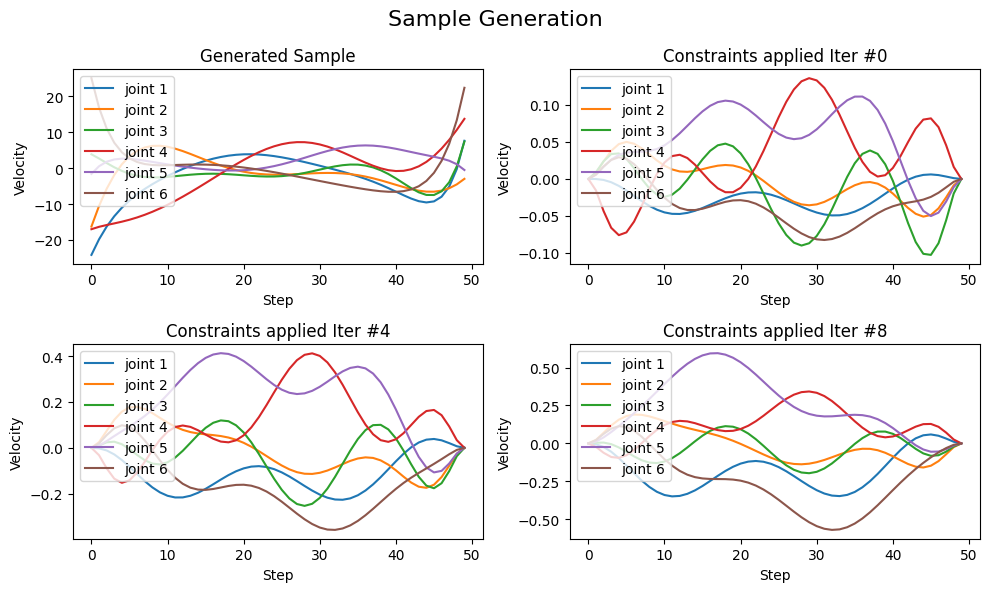

In [16]:

traj = jnp.dot(A_thetadot, xi_samples.T).T[0].reshape(6, 50).T
# traj_filtered = jnp.dot(A_thetadot, xi_filtered.T).T[0].reshape(6, 50).T

fig, axs = plt.subplots(2, 2, figsize=(10, 6))
axs = axs.flatten() 
fig.suptitle('Sample Generation', fontsize=16)

axs[0].plot(traj)
axs[0].set_title("Generated Sample")
axs[0].set_xlabel("Step")
axs[0].set_ylabel("Velocity")
axs[0].legend(['joint 1', 'joint 2', 'joint 3', 'joint 4', 'joint 5', 'joint 6'], loc='upper left')

for i, xi_filtered in enumerate(xi_filtered_list[::4]):

    traj_filtered = jnp.dot(A_thetadot, xi_filtered.T).T[0].reshape(6, 50).T
    axs[i+1].plot(traj_filtered)
    axs[i+1].set_title(f"Constraints applied Iter #{i*4}")
    axs[i+1].set_xlabel("Step")
    axs[i+1].set_ylabel("Velocity")
    axs[i+1].legend(['joint 1', 'joint 2', 'joint 3', 'joint 4', 'joint 5', 'joint 6'], loc='upper left')


plt.tight_layout()
plt.savefig("sample_generation.png")
plt.show()

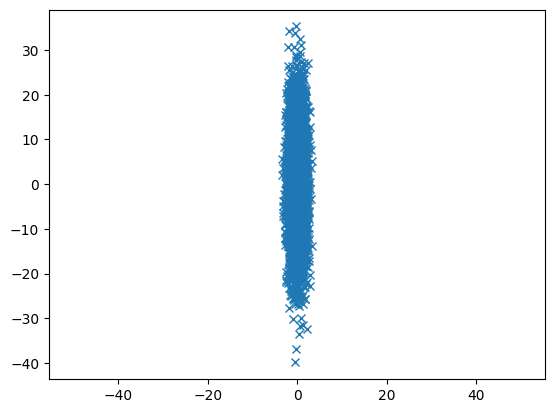

In [18]:
mean = [0, 0]
cov = [[1, 0], [0, 100]]
x, y = np.random.multivariate_normal(mean, cov, 5000).T
plt.plot(x, y, 'x')
plt.axis('equal')
plt.show()